In [8]:
using JuMP, CPLEX
model = Model(CPLEX.Optimizer)
set_attribute(model, "CPX_PARAM_EPINT", 1e-8)
using Printf
using Plots
using Random
using ColorTypes
using Statistics

# Function to calculate Euclidean distance
function calculate_distance(x1, y1, x2, y2)
    return sqrt((x1 - x2)^2 + (y1 - y2)^2)
end

# Function to calculate distance matrix
function calculate_distance_matrix(x,y,nc)
    distances = zeros(length(x),length(x))
    for i in 1:length(x)
        for j in 1:length(y)
            if(i==j)
                distances[i,j] = 10000.00
            elseif((i==1 || j==1)&&(length(x)-i<nc || length(y)-j<nc))
                distances[i, j] = 10000.00
            else
                distances[i, j] = (calculate_distance(x[i], y[i], x[j], y[j]))
            end
        end
    end
    
    return distances

end

function generate_rgb_colors(l::Int)
    colors = [RGB(rand(), rand(), rand()) for _ in 1:l]
    return colors
end
# Define a structure for the customer data
struct Customer
    cust_no::Int
    xcoord::Int
    ycoord::Int
    demand::Int
    ready_time::Int
    due_date::Int
    service_time::Int
end


function displayMap()
    node_labels = [string("N.", i) for i in N]
    # demand_labels = [string("D= ", demands[i-1-np]," TW= ",time_windows[i-1-np]) for i in C]
    demand_labels = [string("D= ", demands[i-1-np]) for i in C]
   
    default(size=(800, 600))
    gr()
    
    # Create a customers scatter plot
    scatter(x_coor_customers, y_coor_customers,
                   title = "Coordinate Plot",
                   xlabel = "X-axis",
                   ylabel = "Y-axis",
                   legend = false, markersize = 6, markercolor = :pink, 
                   marker=:utriangle, markerstrokecolor = :transparent, 
                   markerstrokewidth=0, label = "Customers")

    # Create a parking scatter plot
    scatter!(x_coor[2:1+np], y_coor[2:1+np], 
            title = "Coordinate Plot",
            xlabel = "X-axis", ylabel = "Y-axis",
            legend = false)
 
    # Add the depot point in a different color
    scatter!([x_coor[1]], [y_coor[1]], 
             markersize = 8, markercolor = :yellow)
   
    # Add the initial parking place in a different color
    for p in P
        if PI[p-1]==1
            scatter!([x_coor[p]], [y_coor[p]], 
                 markersize = 8, markercolor = :blue)
        else
            scatter!([x_coor[p]], [y_coor[p]], 
             markersize = 6, markercolor = :white)
        end
    end

    # Add demand annotations for each node
    for i in 1:length(x_coor)
        annotate!(x_coor[i], y_coor[i]+0.3, text(node_labels[i], :center, 4))
        if i<= nc
            # annotate!(x_coor[i+1+np], y_coor[i+1+np]-0.3, text(demand_labels[i], :center, 3)) 
        end
    end 
plot!()
end


function readFile(file_path)
    # Read the file lines
    lines = open(file_path, "r") do file
        readlines(file)
    end

    # Find the index where the customer data starts
    start_index = findfirst(contains.(lines, "CUST NO.")) + 1

    x_coor_customers = []
    x_coor_depot = []
    y_coor_customers = []
    y_coor_depot = []
    demands = []
    time_windows = []
    zeta = 0

    # Parse the customer data
    customers = []
    for i in start_index+1:length(lines)
        line = strip(lines[i])
        if !isempty(line)
            fields = split(line)
            # Depot
            if i == start_index + 1
                push!(x_coor_depot, parse(Int, fields[2]))
                push!(y_coor_depot, parse(Int, fields[3]))
                zeta = parse(Int, fields[6])
            else
                # Customers
                customer = Customer(
                    parse(Int, fields[1]),
                    parse(Int, fields[2]),
                    parse(Int, fields[3]),
                    parse(Int, fields[4]),
                    parse(Int, fields[5]),
                    parse(Int, fields[6]),
                    parse(Int, fields[7])
                )
                push!(customers, customer)
            end
        end
    end
    
    # Fill in the attributes
    for customer in customers
        push!(x_coor_customers, customer.xcoord)
        push!(y_coor_customers, customer.ycoord)
        push!(demands, customer.demand)
        push!(time_windows, (customer.ready_time, customer.due_date))
    end
    
    # Generate parkigns
        # nb_clusters = Int(round(length(x_coor_customers)/10)) 
    x_coor_parkings = [rand(x_coor_customers) for _ in 1:15]
    y_coor_parkings = [rand(y_coor_customers) for _ in 1:15]
    
    # Generate centers of clusters
    # result = kmeans(customer_coor', nb_clusters)
    # x_coor_parkings = vcat(x_coor_current_MM,result.centers[1,:])
    # y_coor_parkings = vcat(y_coor_current_MM,result.centers[2,:])

    return x_coor_customers, y_coor_customers, 
            x_coor_depot, y_coor_depot, 
            x_coor_parkings, y_coor_parkings, 
            demands, time_windows, zeta
    
end

readFile (generic function with 1 method)

In [10]:
#================================SET=========================================#
x_coor_customers, y_coor_customers, 
  x_coor_depot, y_coor_depot, 
  x_coor_parkings, y_coor_parkings, 
  demands, 
  time_windows, zeta = readFile( "50/RC101_50.txt")

# Number of customers
nc = length(x_coor_customers)
print("Number of customers: ", nc)
# Number of parking places
np = length(x_coor_parkings)
P = 2 : np+1 #Set of parking place
C = np+2 : np+nc+1 #Set of customers
A1 = 1 : 1+np #Set of FE arcs
A2 = 2 : 1+np+nc #Set of SE arcs
V1 = 1:1 #Set of FEV
V2 = 1:10 #Set of SEV
N = 1:np+nc+1 #Set of nodes

#==============================PARAMETER=====================================#
Q0 = 5000 #Capacity of FEV
Q1 = 4000 #Capacity of MM
Q2 = 1000 #Capacity of SEV
M = 10000
PI = vcat(ones(Int, 10), zeros(Int, 5)) #Initial parking indicator
shuffle!(PI)
eta1 = 2
eta2 = 1

x_coor = vcat(x_coor_depot, x_coor_parkings, x_coor_customers)
y_coor = vcat(y_coor_depot, y_coor_parkings, y_coor_customers)

node_labels = [string("N.", i) for i in N]
demand_labels = [string(demands[i-1-np]," ",time_windows[i-1-np]) for i in C]

# Disatance matrix
distances = calculate_distance_matrix(x_coor,y_coor,nc)
Vitesse1 = 1
Vitesse2 = 1
println(" ")
TT1 = (distances / Vitesse1)
TT2 = (distances / Vitesse2)

displayMap()
println(mean(demands))

Number of customers: 48 
16.479166666666668


In [3]:
#=========================================================================#
model=Model(CPLEX.Optimizer)

# Decision variable
@variable(model, x[A1,A1], Bin)#Arc(x,y) traversed by FEV
@variable(model, y[A1,A1], Bin)#Arc(x,y) traversed by MM
for i in 1:np+1
    @constraint(model, x[i, i] == 0)
    @constraint(model, y[i, i] == 0)
end

@variable(model, t[A2]>=0, Int) #Arrival time

@variable(model, w[P]>=0, Int) #Amount of freight transported from the depot to parking node

@variable(model, z[V2,A2,A2], Bin)#Arc(x,y) traversed by SEV
for m in V2
    for i in A2
        @constraint(model, z[m,i,i] == 0)
        for j in A2
            if i in P && j in P
                @constraint(model, z[m,i,j]==0)
            end
        end
    end
end

@variable(model, f[A2,A2]>=0,Int) #Load of SEV
#=================================================================================================#
@objective(model, Min,
    sum(distances[i, j] * x[i, j] for i in A1, j in A1 if i != j) +
    sum(distances[i, j] * y[i, j] for i in A1, j in A1 if i != j) +
    sum(sum(distances[i, j] * z[r, i, j] for i in A2, j in A2 if i != j) for r in V2))
#=================================================================================================#

#1 #2
#Flow conservation at parking for FEV
@constraint(model, [i in P], sum(x[j,i] for j in A1 if i != j) == sum(x[i,j] for j in A1 if i != j))
@constraint(model, [i in P], sum(x[i,j] for j in A1 if i != j) <= 1)
#3
#Flow conservation of MM
@constraint(model, [i in P], sum(y[i,j] for j in A1 if i != j) + sum(y[j,i] for j in A1 if i != j)<=1)
#4
#Limit for mobile microhub
@constraint(model, [i in A1, j in A1], y[i,j] <= x[i,j])

#5 #6
#Flow conservation at depot
@constraint(model, sum(x[1,j] for j in A1 if j !=1)==1)
@constraint(model, sum(x[j,1] for j in A1 if j !=1)==1)
@constraint(model, [i in A1], y[1,i] ==0)
@constraint(model, [i in A1], y[i,1] ==0)

#7
#Capacity limit for FEV
@constraint(model, sum(w[p] for p in P)<=Q0)

#8
#Can't tow a MM from parking without MM
@constraint(model, [i in P], sum(y[i,j] for j in A1)<= PI[i-1])
#9
#Can't tow a MM to a parking occupied
@constraint(model, [j in P], sum(y[i,j] for i in A1)<=1-PI[j-1])
#10
#If MM leaves a site, the freight to the site should be zero, otw could be positive
@constraint(model, [p in P], w[p]<=Q1*(1-sum(y[p,j] for j in A1)))

#11
#Link 1st and 2nd
@constraint(model, [p in P], w[p] == sum(f[p,j] for j in A2 if p !=j))

#12
#Capacity limit for MM and connection of FEV
@constraint(model, [p in P], w[p] <= Q1*sum(x[i,p] for i in A1))
#13
#Can't distribute from a site without MM
@constraint(model, [p in P], w[p]<=Q1*(sum(y[i,p] for i in A1)+PI[p-1]))

#14
#Flow consercvation at parking and customer for SEV
@constraint(model, [i in A2, r in V2], sum(z[r,i,j] for j in A2) == sum(z[r,j,i] for j in A2))
#15
#Number of vehicles depart from a Parking node
@constraint(model, [p in P], sum(z[r,p,j] for j in A2 for r in V2) <= length(V2))
#16
#Flow conservation at customer node for SEV
@constraint(model, [i in C], sum(z[r,i,j] for j in A2 for r in V2) == 1)
#17
#Each SEV departs from parking node at most once
@constraint(model, [r in V2, p in P], sum(z[r,p,j] for j in A2) <= 1)
#18
#Customer demand met
@constraint(model, [i in C], sum(f[j,i] for j in A2)-sum(f[i,j] for j in A2)==demands[i-1-np])
#19
#Connection and capacity limit for SEV
@constraint(model, [i in A2, j in A2], f[i,j] <= Q2 * sum(z[r,i,j] for r in V2))

#20
@constraint(model, sum(TT1[i,j]*x[i,j] for i in A1 for j in A1) + eta1*sum(PI[p-1]*x[i,p] for p in P for i in A1)<= zeta)

#21
@constraint(model, [i in C, j in P, r in V2], t[i]+TT2[i,j]+eta2 <= zeta + M*(1 - z[r,i,j]))
#22
#Time constraint for FEV and MTZ
@constraint(model, [i in P, j in P], t[i] + eta1*(1-x[i,j]) + TT1[i,j]*x[i,j] <= t[j] + M*(1 - x[i,j]))

#23
#Time constraint for SEV and MTZ
@constraint(model, [i in C, j in C, r in V2], t[i]+eta2*(1-z[r,i,j])+TT2[i,j]*z[r,i,j] <= t[j]+M * (1 - z[r,i,j]))

#24
@constraint(model, [i in C], t[i] >= time_windows[i-1-np][1])
@constraint(model, [i in C], t[i] <= time_windows[i-1-np][2])

#25 26
#Arrival time initialization
@constraint(model, [i in P], TT1[1,i] * x[1,i] <= t[i])
@constraint(model, [p in P, j in C, r in V2], t[p] + TT2[p,j] * z[r,p,j] <= t[j])

3-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},3,...} with index sets:
    Dimension 1, 2:16
    Dimension 2, 17:36
    Dimension 3, 1:10
And data, a 15×20×10 Array{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}, 3}:
[:, :, 1] =
 t[2] - t[17] + 61.35144660071187 z[1,2,17] ≤ 0     …  t[2] - t[36] + 9.433981132056603 z[1,2,36] ≤ 0
 t[3] - t[17] + 50.24937810560445 z[1,3,17] ≤ 0        t[3] - t[36] + 20 z[1,3,36] ≤ 0
 t[4] - t[17] + 10.198039027185569 z[1,4,17] ≤ 0       t[4] - t[36] + 54.120236510939236 z[1,4,36] ≤ 0
 t[5] - t[17] + 53 z[1,5,17] ≤ 0                       t[5] - t[36] + 25.179356624028344 z[1,5,36] ≤ 0
 t[6] - t[17] + 61.35144660071187 z[1,6,17] ≤ 0        t[6] - t[36] + 9.433981132056603 z[1,6,36] ≤ 0
 t[7] - t[17] + 20.09975124224178 z

In [4]:
set_optimizer_attribute(model, "CPX_PARAM_TILIM", 60*15)
set_optimizer_attribute(model, "CPX_PARAM_MIPSEARCH",2)
# Solve the model
optimize!(model)


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_MIP_Strategy_Search                     2
CPXPARAM_TimeLimit                               900
Tried aggregator 1 time.
MIP Presolve eliminated 12549 rows and 4989 columns.
MIP Presolve modified 3027 coefficients.
Reduced MIP has 2560 rows, 9048 columns, and 38256 nonzeros.
Reduced MIP has 8210 binaries, 838 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (36.79 ticks)
Probing fixed 32 vars, tightened 492 bounds.
Probing time = 0.08 sec. (75.66 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 32 rows and 32 columns.
MIP Presolve modified 180 coefficients.
Reduced MIP has 2528 rows, 9016 columns, and 38040 nonzeros.
Reduced MIP has 8178 binaries, 838 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (27.70 ticks)
Probing time = 0.02 sec. (6.63 ticks)
Clique table members: 24241.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parall

In [5]:

# Check the solver status
status = termination_status(model)
println("Solver status: ", status)

# Get the solution if it exists
if status == MOI.OPTIMAL || status == MOI.TIME_LIMIT
    println("Total distance traveled: ", objective_value(model))
else
    println("No feasible solution found.")
end

Solver status: OPTIMAL
Total distance traveled: 220.19836377953797


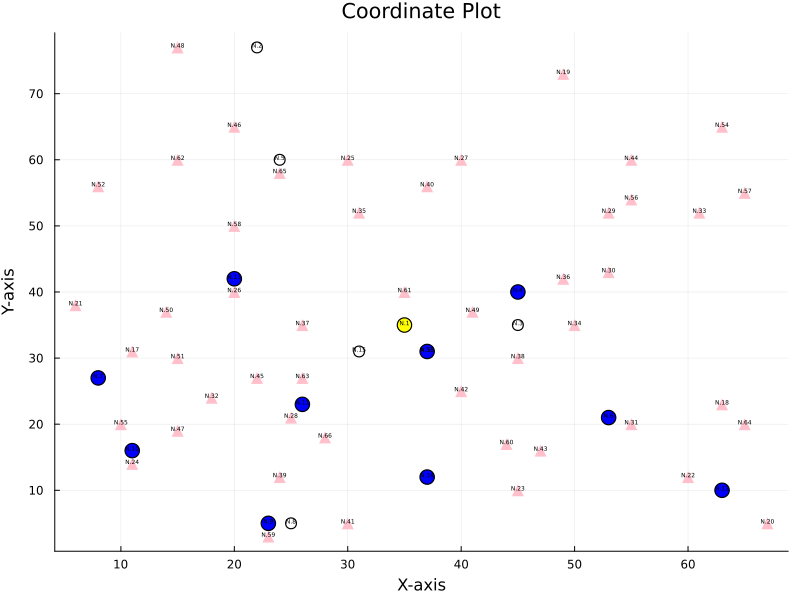

In [11]:
displayMap()

if termination_status(model) == MOI.OPTIMAL
    time_labels = [string("t= ", round(value(t[i]))) for i in A2]
    SEV_labels = [string("z(",r,",",i,",",j,")= ", round(value(z[r,i,j]))) for r in V2 for i in A2 for j in A2]
    light_green = RGBA(0.5, 1.0, 0.5, 1.0)
    color_list = generate_rgb_colors(length(V2))
    # Add FEV arcs between the locations if they are traversed
    for i in A1
        for j in A1         
            if round(value(y[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = light_green, label = "", linealpha=4, lw=4)
            end
            if round(value(x[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = :red, label = "")
            end
        end
    end
    
    # Add SEV arcs between the locations if they are traverse
    for r in V2
        for i in A2
            if value(t[i])!=0 annotate!(x_coor[i]+0.5, y_coor[i], text(time_labels[i-1], :center, 6)) end
            for j in A2
                if round(value(z[r, i, j])) == 1
                    plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], line=:arrow, color = color_list[r] )
                    mid_x = (x_coor[i] + x_coor[j]) / 2 
                    mid_y = (y_coor[i] + y_coor[j]) / 2 + 0.2
                    annotate!(mid_x, mid_y, text(SEV_labels[(r-1)*(np+nc)*(np+nc)+(i-2)*(np+nc)+j-1],6 ,:blue))
                    if value(f[i,j]) != 0
                        mid_x = (x_coor[i] + x_coor[j]) / 2
                        mid_y = (y_coor[i] + y_coor[j]) / 2 - 0.2
                    end
                end
            end
        end
    end
end
plot!()

In [17]:
print(x)
for i in 1:10
    for j in 1:10
        print(value(x[i,j]))
    end
end
# for i in A1
#     for j in A1 if round(value(x[i,j]))==1 print("  x[",i,",",j,"]=",round(value(x[i,j]))) end end
# end
# println(" ")
# for i in A1
#     for j in A1 if value(y[i,j])==1 print("  y[",i,",",j,"]=",value(y[i,j])) end end
# end
# println(" ")
# for i in A2 print("  t[",i,"]=",value(t[i])) end
# println(" ")
# for r in V2
#     for i in A2
#         for j in A2 if round(value(z[r,i,j]))==1 print("  z[",r,",",i,",",j,"]=",round(value(z[r,i,j]))) end end
#     end
#     println("") 
#     println("")
# end
# println(" ")
# for i in P
#     print("  w[",i,"]=",value(w[i]))
# end
# println(" ")
# for i in A2
#     for j in A2 if value(f[i,j]) != 0 print("  f[",i,",",j,"]=",value(f[i,j])) end end
# end

2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, 1:16
    Dimension 2, 1:16
And data, a 16×16 Matrix{VariableRef}:
 x[1,1]   x[1,2]   x[1,3]   x[1,4]   x[1,5]   x[1,6]   x[1,7]   x[1,8]   x[1,9]   x[1,10]   x[1,11]   x[1,12]   x[1,13]   x[1,14]   x[1,15]   x[1,16]
 x[2,1]   x[2,2]   x[2,3]   x[2,4]   x[2,5]   x[2,6]   x[2,7]   x[2,8]   x[2,9]   x[2,10]   x[2,11]   x[2,12]   x[2,13]   x[2,14]   x[2,15]   x[2,16]
 x[3,1]   x[3,2]   x[3,3]   x[3,4]   x[3,5]   x[3,6]   x[3,7]   x[3,8]   x[3,9]   x[3,10]   x[3,11]   x[3,12]   x[3,13]   x[3,14]   x[3,15]   x[3,16]
 x[4,1]   x[4,2]   x[4,3]   x[4,4]   x[4,5]   x[4,6]   x[4,7]   x[4,8]   x[4,9]   x[4,10]   x[4,11]   x[4,12]   x[4,13]   x[4,14]   x[4,15]   x[4,16]
 x[5,1]   x[5,2]   x[5,3]   x[5,4]   x[5,5]   x[5,6]   x[5,7]   x[5,8]   x[5,9]   x[5,10]   x[5,11]   x[5,12]   x[5,13]   x[5,14]   x[5,15]   x[5,16]
 x[6,1]   x[6,2]   x[6,3]   x[6,4]   x[6,5]   x[6,6]   x[6,7]   x[6,8]   x[6,9]   x[6,10]   x[6,11]   

MathOptInterface.ResultIndexBoundsError{MathOptInterface.VariablePrimal}: Result index of attribute MathOptInterface.VariablePrimal(1) out of bounds. There are currently 0 solution(s) in the model.

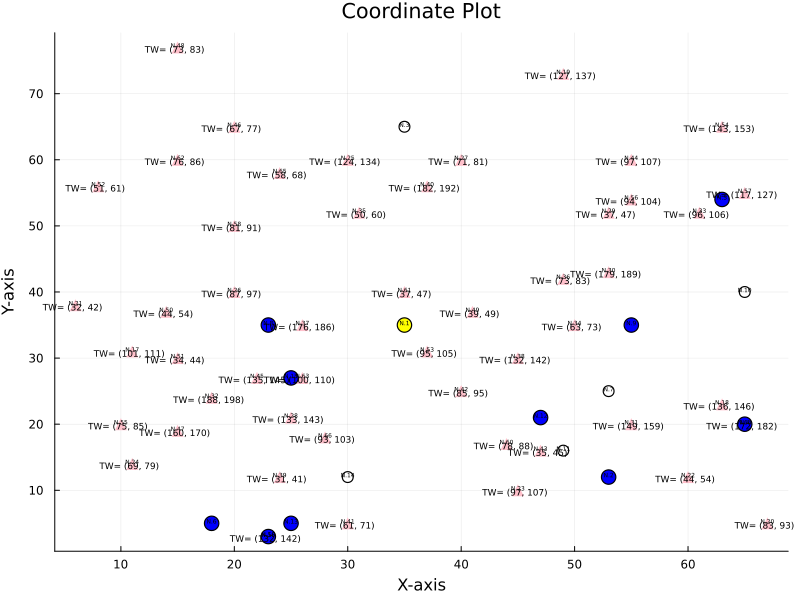

In [7]:
displayMap()
speed1_labels = [string("TT1(",i,",",j,")= ", round(value(TT1[i,j]), digits=2)) for i in N for j in N]
speed2_labels = [string("TT2(",i,",",j,")= ", round(value(TT2[i,j]), digits=2)) for i in N for j in N]
demand_labels = [string("TW= ",time_windows[i-1-np]) for i in C]

for i in C
    annotate!(x_coor[i]-0.3, y_coor[i]-0.3, text(demand_labels[i-1-np], :center, 6)) 
end 

if termination_status(model) == MOI.OPTIMAL
    time_labels = [string("t= ", round(value(t[i]))) for i in A2]
    SEV_labels = [string("z(",r,",",i,",",j,")= ", round(value(z[r,i,j]))) for r in V2 for i in A2 for j in A2]
    light_green = RGBA(0.5, 1.0, 0.5, 1.0)
    color_list = generate_rgb_colors(length(V2))
    # Add FEV arcs between the locations if they are traversed
    for i in A1
        for j in A1         
            if round(value(y[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = light_green, label = "", linealpha=4, lw=4)
            end
            if round(value(x[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = :red, label = "")
                mid_x = (x_coor[i] + x_coor[j]) / 2
                mid_y = (y_coor[i] + y_coor[j]) / 2 +0.2
                annotate!(mid_x, mid_y, text(speed1_labels[(i-1)*(np+nc+1)+j],6 ,:blue))
            end
        end
    end
    
    # Add SEV arcs between the locations if they are traverse
    for r in V2
        for i in A2
            annotate!(x_coor[i]+0.5, y_coor[i], text(time_labels[i-1], :center, 6))
            for j in A2
                if round(value(z[r, i, j])) == 1
                    plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], line=:arrow, color = color_list[r] )
                    mid_x = (x_coor[i] + x_coor[j]) / 2 
                    mid_y = (y_coor[i] + y_coor[j]) / 2 + 0.2
                    # annotate!(mid_x, mid_y, text(SEV_labels[(r-1)*(np+nc)*(np+nc)+(i-2)*(np+nc)+j-1],6 ,:blue))
                    annotate!(mid_x, mid_y, text(speed2_labels[(i-1)*(np+nc+1)+j],6 ,:blue))
                end
            end
        end
    end
end
plot!()

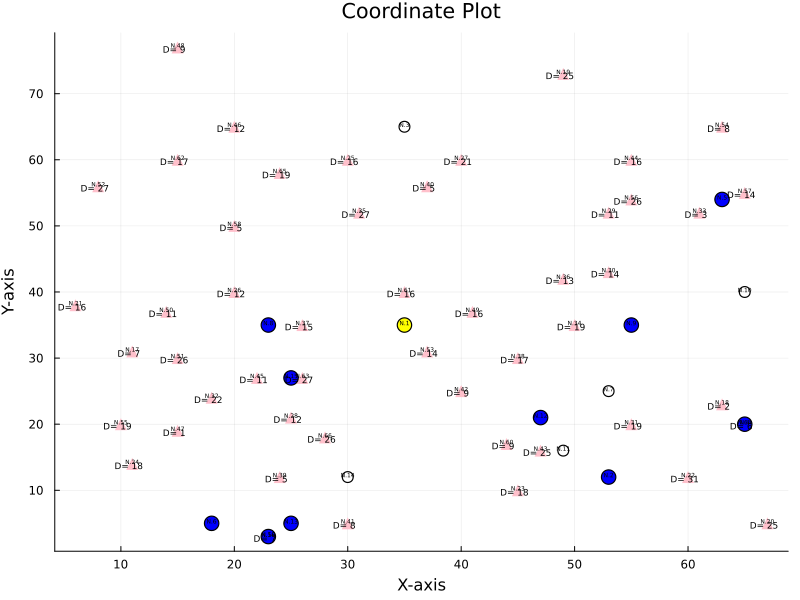

In [8]:
displayMap()
demand_labels = [string("D= ", demands[i-1-np]) for i in C]
for i in C
    annotate!(x_coor[i]-0.3, y_coor[i]-0.3, text(demand_labels[i-1-np], :center, 6)) 
end 


if termination_status(model) == MOI.OPTIMAL
    time_labels = [string("t= ", value(t[i])) for i in A2]
    flow_labels = [string("f(",i,",",j,")= ", floor(value(f[i,j]))) for i in A2 for j in A2]
    loan_labels = [string("w= ", floor(value(w[i]))) for i in P]
    light_green = RGBA(0.5, 1.0, 0.5, 1.0)
    color_list = generate_rgb_colors(length(V2))
    # Add FEV arcs between the locations if they are traversed
    for i in A1
        for j in A1         
            if round(value(y[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = light_green, label = "", linealpha=4, lw=4)
            end
            if round(value(x[i, j])) == 1
                plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], 
                      line=:arrow,color = :red, label = "")
            end
        end
    end
    
    # Add SEV arcs between the locations if they are traverse
    for r in V2
        for i in A2
#             annotate!(x_coor[i]+0.5, y_coor[i], text(time_labels[i-1], :center, 6))
            for j in A2
                if round(value(z[r, i, j])) == 1
                    plot!([x_coor[i], x_coor[j]], [y_coor[i], y_coor[j]], line=:arrow, color = color_list[r] )
                    mid_x = (x_coor[i] + x_coor[j]) / 2
                    mid_y = (y_coor[i] + y_coor[j]) / 2 + 0.2
#                     annotate!(mid_x, mid_y, text(SEV_labels[(r-1)*(np+nc)*(np+nc)+(i-2)*(np+nc)+j-1],6 ,:blue))
                    
                end
                if value(f[i,j]) != 0
                    mid_x = (x_coor[i] + x_coor[j]) / 2
                    mid_y = (y_coor[i] + y_coor[j]) / 2 - 0.2
                    annotate!(mid_x, mid_y, text(flow_labels[(i-2)*(np+nc)+j-1],6 ,:blue))
                end
            end
        end
    end
    
    for p in P
        annotate!(x_coor[p]+0.2,y_coor[p]-0.2, text(loan_labels[p-1],6 ,:blue))
    end
end
plot!()